# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
import numpy as np
import itertools 
import math


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50


## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


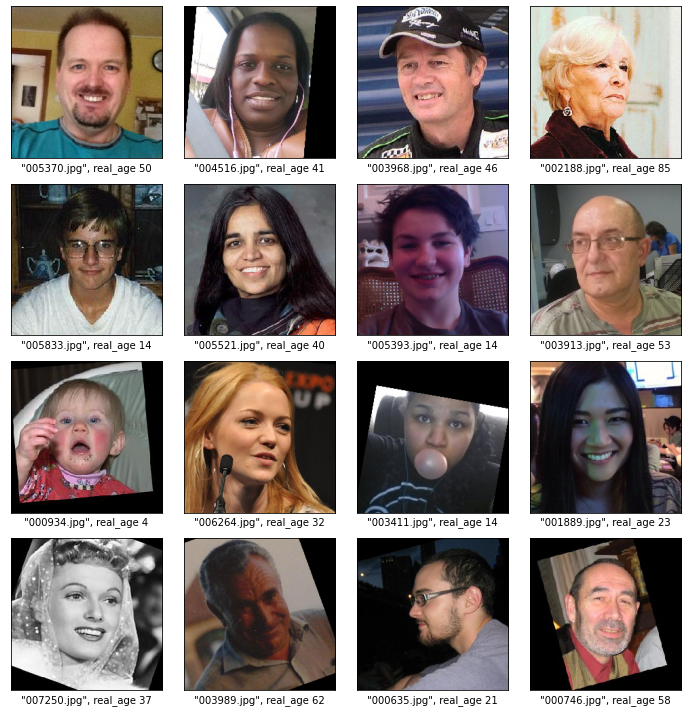

In [6]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1) 
    plt.imshow(train_gen_flow[0][0][i]) 
    plt.xlabel(
        f'"{train_gen_flow.filenames[train_gen_flow.index_array[i]]}", real_age {train_gen_flow[0][1][i]}'
    )
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


### График распределения возраста

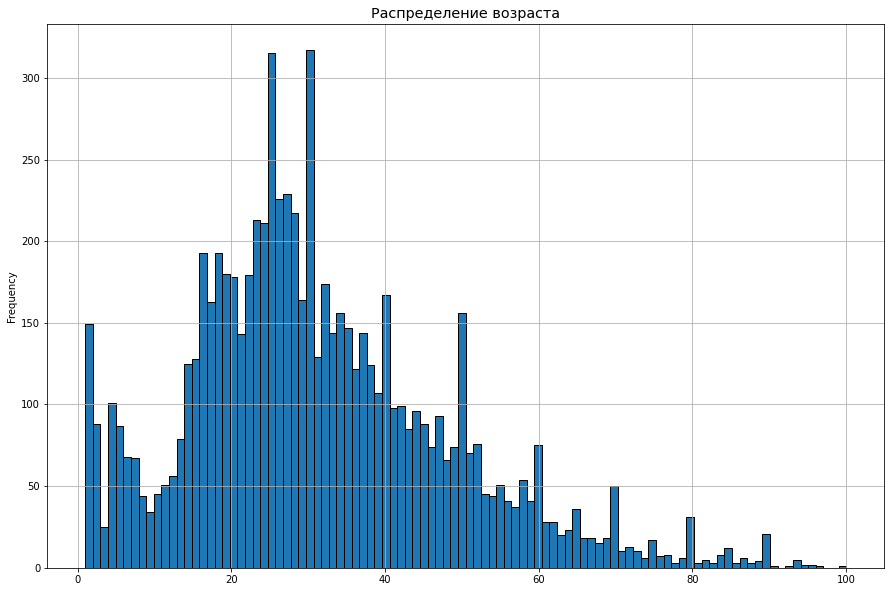

In [7]:
plt.figure(figsize=(15,10))
plt.title('Распределение возраста', fontsize='x-large')
labels['real_age'].plot.hist(bins=100, grid=True, edgecolor='black')
plt.show()

**Выводы**
- по фотографиям видно, что аугментация уже была проведена
- большинство реальных людей в датасете в возрачте от 20ти до 40ка лет.
- можно обучать модель

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='training',
          seed=12345)
    
 
    #target_train = np.load(path + 'train_target.npy')
    #features_train = features_train.reshape(-1, 28, 28, 1) / 255.0
    ##features_test = features_test.reshape(-1, 28, 28, 1) / 255.0
    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='validation',
          seed=12345)
    
 
    #target_train = np.load(path + 'train_target.npy')
    #features_train = features_train.reshape(-1, 28, 28, 1) / 255.0
    ##features_test = features_test.reshape(-1, 28, 28, 1) / 255.0
    return test_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                         weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                         include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
 
    return model
 
 
def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
 
    features_train = train_datagen_flow
    features_test = test_datagen_flow
    model.fit(features_train, 
              validation_data=features_test,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

```

2023-03-07 14:21:27.978505: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6

2023-03-07 14:21:27.980499: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6

2023-03-07 14:21:28.831170: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1

2023-03-07 14:21:28.840825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2023-03-07 14:21:28.840880: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-03-07 14:21:28.840911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-03-07 14:21:28.842853: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2023-03-07 14:21:28.843193: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2023-03-07 14:21:28.845203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2023-03-07 14:21:28.846360: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2023-03-07 14:21:28.846416: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-03-07 14:21:28.849994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

Using TensorFlow backend.

Found 6073 validated image filenames.

Found 1518 validated image filenames.

2023-03-07 14:21:29.009259: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA

2023-03-07 14:21:29.015388: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz

2023-03-07 14:21:29.015948: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f18fd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

2023-03-07 14:21:29.015973: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version

2023-03-07 14:21:29.165240: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4579130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

2023-03-07 14:21:29.165290: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0

2023-03-07 14:21:29.167866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2023-03-07 14:21:29.167932: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-03-07 14:21:29.167946: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-03-07 14:21:29.167977: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2023-03-07 14:21:29.167991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2023-03-07 14:21:29.168004: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2023-03-07 14:21:29.168016: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2023-03-07 14:21:29.168027: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-03-07 14:21:29.172240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2023-03-07 14:21:29.172360: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-03-07 14:21:29.540504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:

2023-03-07 14:21:29.540559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 

2023-03-07 14:21:29.540567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 

2023-03-07 14:21:29.544335: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

2023-03-07 14:21:29.544387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)

<class 'keras.engine.sequential.Sequential'>

Epoch 1/5

2023-03-07 14:22:15.602459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-03-07 14:22:15.942308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

 - 83s - loss: 230.5505 - mae: 10.8239 - val_loss: 1078.8116 - val_mae: 24.8188

Epoch 2/5

 - 81s - loss: 66.7237 - mae: 6.1852 - val_loss: 967.2516 - val_mae: 23.0521

Epoch 3/5

 - 73s - loss: 35.7014 - mae: 4.5835 - val_loss: 207.6259 - val_mae: 11.9392

Epoch 4/5

 - 85s - loss: 21.8745 - mae: 3.5870 - val_loss: 29.0052 - val_mae: 7.7230

Epoch 5/5

 - 69s - loss: 19.0595 - mae: 3.3848 - val_loss: 96.8576 - val_mae: 6.4097

Test MAE: 6.4097


```

**Выводы**
Test MAE: 6.4097. Это соответствует требованиям.


## Анализ обученной модели

В ходе выполнения пронета нами был произведен иследовательский анализ данных и построена.  модель. Был построен график распределения возраста Большинство людей в датасете в возрасте от 20ти до 40 лет. Для модели была выбрана архитектупа Resnet и оптимизатором Adam.Модель обучалась 5 эпох. Метрика MAE равна 6.4097 это соответствует требованиям.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы